# Multi-Armed Bandit (k-Armed Bandit)


## References

* https://en.wikipedia.org/wiki/Multi-armed_bandit

In [31]:
from datetime import timedelta, datetime, date
import time

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from IPython.display import display, clear_output

## Theory


* Iteratively Selects One of the multiple fixed choices
* These choices are called `arms` or `actions` or `levers`
* Property of each choice is partially known at the time of allocation but become better understood as the time passes.
    * Either we know it earlier (Partially)
    * or we'll know it with time
* these arms are `Independent`
* This algorithm works as `Best Arm Identification`
* Target here is to `Minimize Regret`
* Exploration $\leftrightarrow$ Exploitation

> Objective
>> `Minimize` the sum of rewards earned through a sequence of lever pulls.
>>
>> Each machines provides a random reward from a probability distribution specific to the machine(not known apriori)


<!-- 
## Example

* Lets say a player enters a casino to play slot machines.
* there are 10 machines, but not all machines have same reward (win %) per gamble.
* Now the player had  -->

## Actions/ Levers

In [32]:
class Levers:
    @staticmethod
    def lever_1(mu=10, sigma=5):
        return np.random.normal(mu, sigma)

    @staticmethod
    def lever_2(mu=8, sigma=3):
        return np.random.normal(mu, sigma)

    @staticmethod
    def lever_3(mu=5, sigma=25):
        return np.random.normal(mu, sigma)


levers = ["lever_1", "lever_2", "lever_3"]

In [33]:
def levers_cyclic_iter(levers):
    i = 0
    while True:
        if i >= len(levers):
            i = 0
        yield levers[i]
        i += 1

In [34]:
def print_df(df, sleep_time):
    clear_output(wait=True)
    display(df)
    time.sleep(sleep_time)

In [35]:
def random_choose_lever(levers):
    return np.random.choice(levers, size=None, replace=True, p=None)

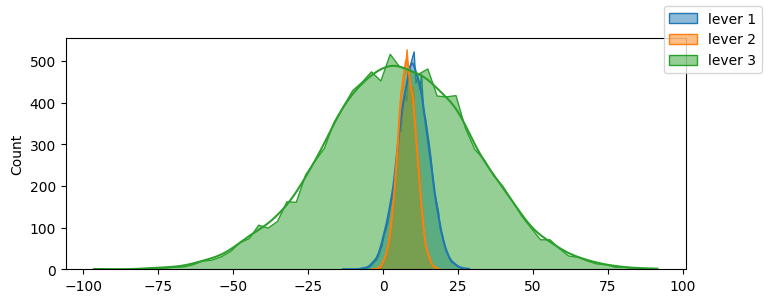

In [36]:
fig, ax = plt.subplots(1, 1, figsize=(8, 3))

params = {
    "kde": True,
    "element": "poly",
    "ax": ax,
}
sns.histplot([Levers.lever_1() for _ in range(10000)], label="lever 1", **params)
sns.histplot([Levers.lever_2() for _ in range(10000)], label="lever 2", **params)
sns.histplot([Levers.lever_3() for _ in range(10000)], label="lever 3", **params)
fig.legend()
fig.show()

## Reward & Regret

In [37]:
def calculate_regret(total_reward, max_reward, N):
    optimum_reward = max_reward * N
    regret = optimum_reward - total_reward
    return regret

In [38]:
def get_metrics(rewardsdf: pd.DataFrame, verbose=True):
    aggdf = rewardsdf.groupby(by=["lever", "decision"], as_index=False).agg(
        ts_count=("ts", "count"),
        ts_min=("ts", "min"),
        reward_min=("reward", "min"),
        reward_mean=("reward", "mean"),
        reward_max=("reward", "max"),
        reward_sum=("reward", "sum"),
        reward_std=("reward", "std"),
    ).sort_values(by=["ts_min"])
    max_reward = aggdf["reward_mean"].max()
    total_reward = aggdf["reward_sum"].sum()
    n_iters = aggdf["ts_count"].sum()
    optimum_reward = max_reward * len(rewardsdf)

    max_reward_lever_record = aggdf[aggdf["reward_mean"] == max_reward]
    next_chosen_lever = max_reward_lever_record["lever"].iloc[0]

    regret = calculate_regret(
        total_reward=total_reward, max_reward=max_reward, N=n_iters
    )
    if verbose:
        print_df(aggdf, 0.2)
        print(
            f"""
        Iterations      : {n_iters}
        Optimum Reward  : {optimum_reward}
        Total Reward    : {total_reward} 
        Regret          : {regret}
        """
        )
        # print(aggdf.to_string(justify="left", line_width=200), end="\r")
    return (next_chosen_lever, aggdf, optimum_reward, total_reward, regret)

In [39]:
def plot_reward(rewarddf, x="ts"):
    rewarddf["decision-lever"] = rewarddf["decision"] + "-" + rewarddf["lever"]
    fig, ax = plt.subplots(2, 1, figsize=(15, 8))

    line_plot_params = {
        "alpha": 0.6,
        "color": "grey",
        "linewidth": 0.5,
    }

    sns.lineplot(data=rewarddf, x=x, y="reward", ax=ax[0], **line_plot_params)
    sns.scatterplot(data=rewarddf, x=x, y="reward", hue="decision-lever", ax=ax[0])

    sns.lineplot(data=rewarddf, x=x, y="reward_cumsum", ax=ax[1], **line_plot_params)
    sns.scatterplot(
        data=rewarddf, x=x, y="reward_cumsum", hue="decision-lever", ax=ax[1]
    )

    fig.autofmt_xdate(rotation=45)
    fig.tight_layout()
    return fig

## Exploration & Exploitation

In [40]:
class Model:
    def __init__(self, levers) -> None:
        self.ts_idx = datetime(2024, 1, 1, 0, 0, 0)
        self.timedelta = timedelta(minutes=30)
        self.seq_idx = 0
        self.decision_idx = 0
        self.rewards = pd.DataFrame(columns=["decision_idx", "decision", "seq", "ts", "lever", "reward"])
        self.levers = levers
        self.chosen_lever = None

    def get_decision_idx(self, decision):

        if (
            len(self.rewards) == 0
            or self.rewards["decision"].iloc[len(self.rewards) - 1 ] != decision
        ):
            self.decision_idx += 1
        return self.decision_idx

    def get_lever(self):
        if self.chosen_lever is None:
            if len(self.rewards) == 0:
                raise ValueError("First run explore to get some data")
            prev_iter_rewardsdf = self.rewards[self.rewards["decision_idx"] == self.rewards["decision_idx"].iloc[-1]]
            self.chosen_lever = get_metrics(prev_iter_rewardsdf, verbose=False)[0]
        return self.chosen_lever

    def update_rewards(self, reward_payload):
        self.rewards.loc[len(self.rewards)] = reward_payload
        # print(self.rewardsdf.tail(5).to_string(justify="left", line_width=200), end="\r")
        print_df(self.rewardsdf, 0.2)

    def explore(self, enforce_lever=None):
        self.chosen_lever = None
        explore_lever = enforce_lever or random_choose_lever(self.levers)
        reward = getattr(Levers, explore_lever)()

        self.ts_idx += self.timedelta
        self.seq_idx += 1

        decision = "explore"
        decision_idx = self.get_decision_idx(decision)
        self.update_rewards([decision_idx, decision, self.seq_idx, self.ts_idx, explore_lever, reward])

    def exploit(self):
        chosen_lever = self.get_lever()
        reward = getattr(Levers, chosen_lever)()

        self.ts_idx += self.timedelta
        self.seq_idx += 1

        decision = "exploit"
        decision_idx = self.get_decision_idx(decision)
        self.update_rewards([decision_idx, decision, self.seq_idx, self.ts_idx, chosen_lever, reward])
        
    @property
    def rewardsdf(self):
        df = self.rewards.copy()
        df.insert(len(df.columns), column="reward_cumsum", value=df["reward"].cumsum())
        return df

## Only Exploration


### Stochastic

In [41]:
model = Model(levers)

for _ in range(100):
    model.explore()


,decision_idx,decision,seq,ts,lever,reward,reward_cumsum
0,1,explore,1,2024-01-01 00:30:00,lever_2,11.911693,11.911693
1,1,explore,2,2024-01-01 01:00:00,lever_3,12.517208,24.428900
2,1,explore,3,2024-01-01 01:30:00,lever_1,12.722496,37.151396
3,1,explore,4,2024-01-01 02:00:00,lever_2,10.863864,48.015260
4,1,explore,5,2024-01-01 02:30:00,lever_3,-23.663114,24.352146
...,...,...,...,...,...,...,...
95,1,explore,96,2024-01-03 00:00:00,lever_2,7.015213,980.592650
96,1,explore,97,2024-01-03 00:30:00,lever_3,0.336474,980.929123
97,1,explore,98,2024-01-03 01:00:00,lever_2,2.485143,983.414267
98,1,explore,99,2024-01-03 01:30:00,lever_2,7.992930,991.407196


,lever,decision,ts_count,ts_min,reward_min,reward_mean,reward_max,reward_sum,reward_std
1,lever_2,explore,32,2024-01-01 00:30:00,2.424225,7.695370,13.175569,246.251841,2.599079
2,lever_3,explore,34,2024-01-01 01:00:00,-28.474280,11.636900,47.772858,395.654585,22.254322
0,lever_1,explore,34,2024-01-01 01:30:00,3.080009,10.603896,20.770558,360.532475,4.842755



        Iterations      : 100
        Optimum Reward  : 1163.6899559965639
        Total Reward    : 1002.4389001408622 
        Regret          : 161.25105585570168
        


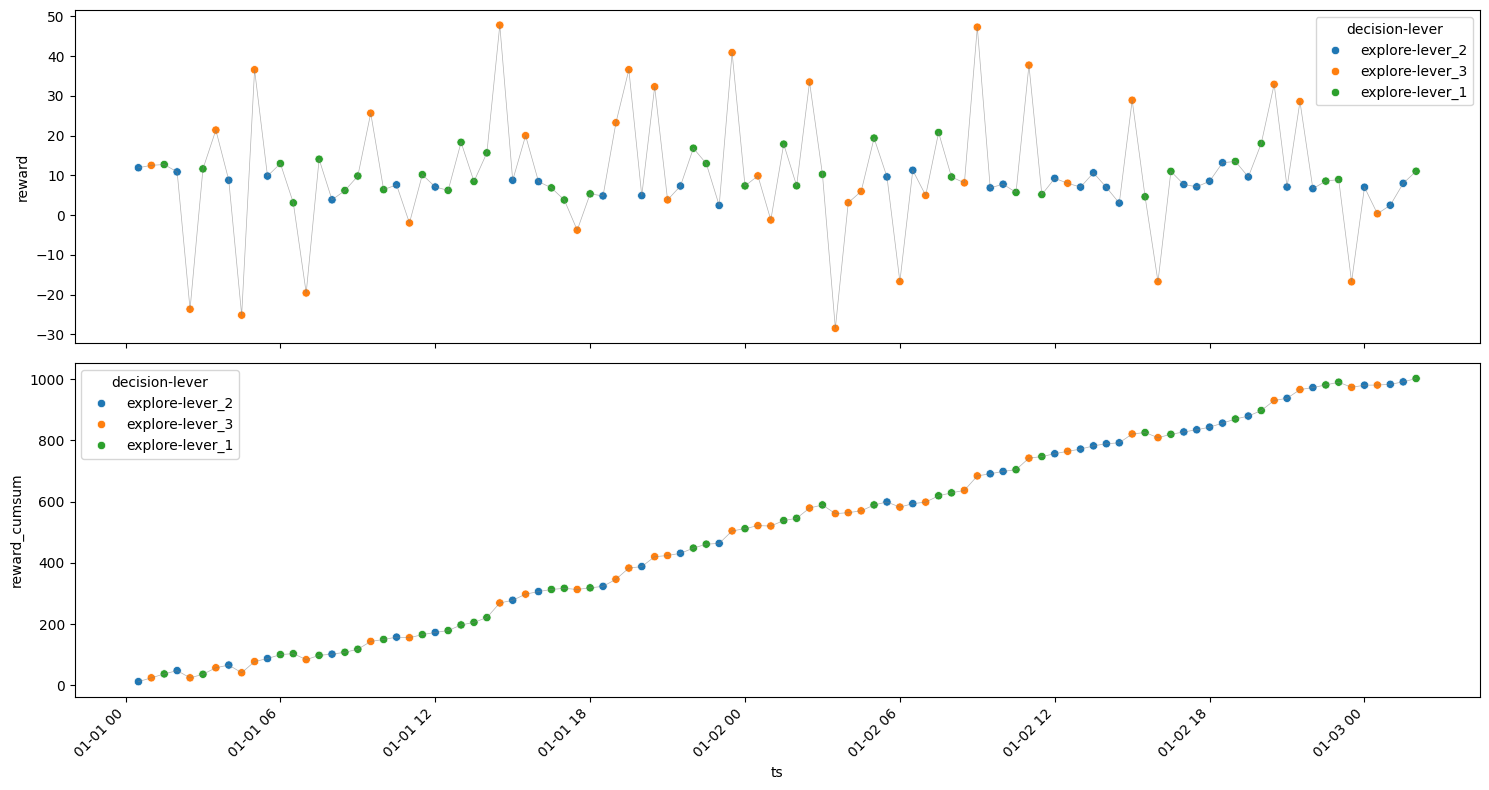

In [42]:
explore_rewarddf = model.rewardsdf
get_metrics(explore_rewarddf);
plot_reward(explore_rewarddf);

### Sequential

In [43]:
levers_iterator = levers_cyclic_iter(levers)
model = Model(levers)

for _ in range(100):
    model.explore(next(levers_iterator))


,decision_idx,decision,seq,ts,lever,reward,reward_cumsum
0,1,explore,1,2024-01-01 00:30:00,lever_1,18.027778,18.027778
1,1,explore,2,2024-01-01 01:00:00,lever_2,9.167212,27.194990
2,1,explore,3,2024-01-01 01:30:00,lever_3,-58.481226,-31.286236
3,1,explore,4,2024-01-01 02:00:00,lever_1,8.366543,-22.919693
4,1,explore,5,2024-01-01 02:30:00,lever_2,3.676796,-19.242896
...,...,...,...,...,...,...,...
95,1,explore,96,2024-01-03 00:00:00,lever_3,-16.615862,447.789931
96,1,explore,97,2024-01-03 00:30:00,lever_1,4.315333,452.105264
97,1,explore,98,2024-01-03 01:00:00,lever_2,7.977049,460.082313
98,1,explore,99,2024-01-03 01:30:00,lever_3,46.489218,506.571531


,lever,decision,ts_count,ts_min,reward_min,reward_mean,reward_max,reward_sum,reward_std
0,lever_1,explore,34,2024-01-01 00:30:00,-1.080233,11.923517,22.157841,405.399569,5.661299
1,lever_2,explore,33,2024-01-01 01:00:00,1.625438,8.615843,12.916223,284.322834,2.676346
2,lever_3,explore,33,2024-01-01 01:30:00,-62.680380,-5.362964,49.677933,-176.977804,28.103381



        Iterations      : 100
        Optimum Reward  : 1192.3516721519268
        Total Reward    : 512.7445987299322 
        Regret          : 679.6070734219945
        


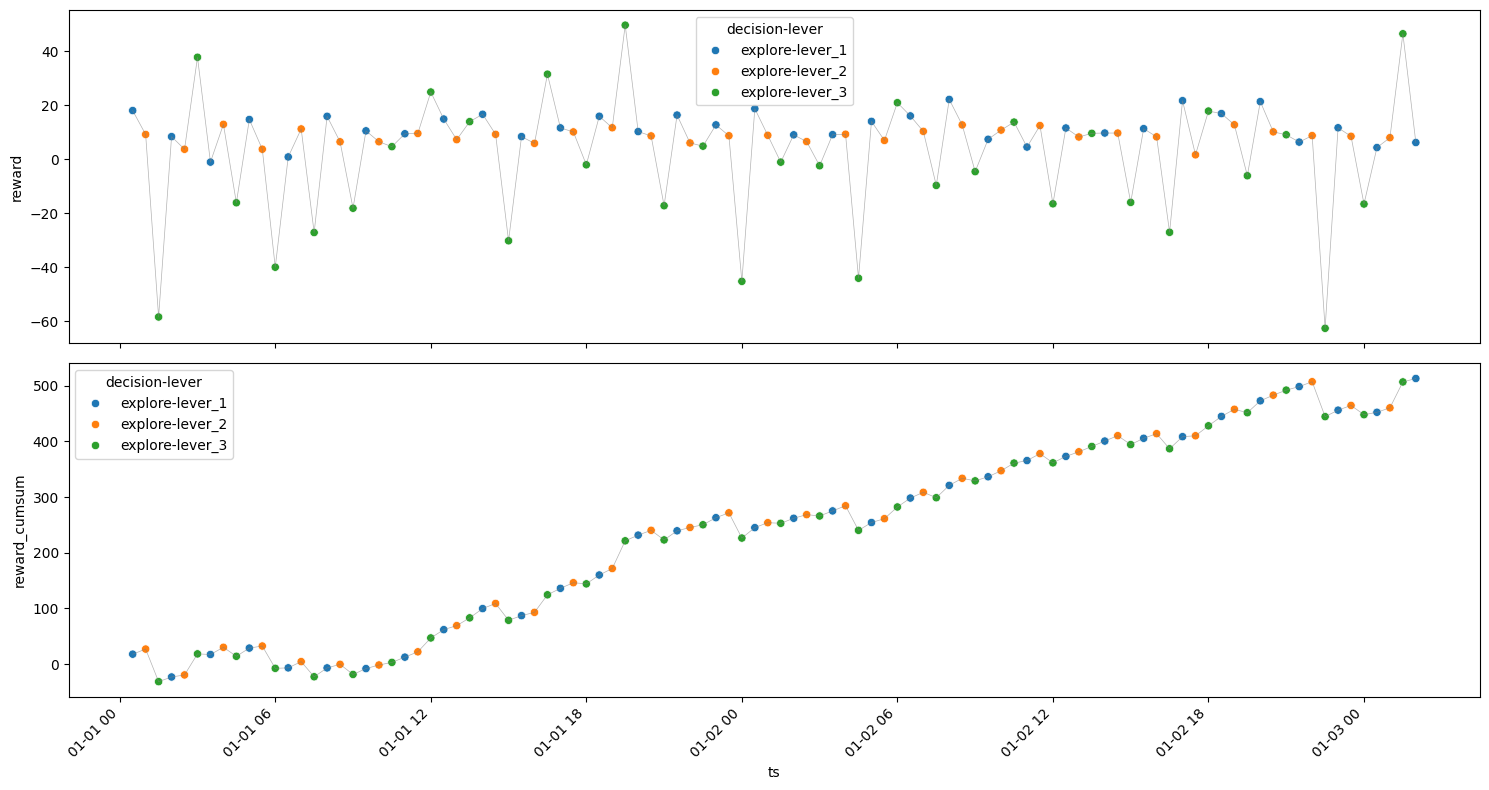

In [44]:
explore_rewarddf = model.rewardsdf
get_metrics(explore_rewarddf);
plot_reward(explore_rewarddf);

## Only Exploitation


In [45]:
levers_iterator = levers_cyclic_iter(levers)

model = Model(levers)

for _ in range(3):
    model.explore(next(levers_iterator))

for i in range(97):
    model.exploit()


,decision_idx,decision,seq,ts,lever,reward,reward_cumsum
0,1,explore,1,2024-01-01 00:30:00,lever_1,12.353381,12.353381
1,1,explore,2,2024-01-01 01:00:00,lever_2,4.680309,17.033690
2,1,explore,3,2024-01-01 01:30:00,lever_3,26.384970,43.418660
3,2,exploit,4,2024-01-01 02:00:00,lever_3,40.831923,84.250583
4,2,exploit,5,2024-01-01 02:30:00,lever_3,32.329632,116.580215
...,...,...,...,...,...,...,...
95,2,exploit,96,2024-01-03 00:00:00,lever_3,-34.815623,1038.349562
96,2,exploit,97,2024-01-03 00:30:00,lever_3,35.731498,1074.081060
97,2,exploit,98,2024-01-03 01:00:00,lever_3,-40.761210,1033.319850
98,2,exploit,99,2024-01-03 01:30:00,lever_3,-1.407034,1031.912816


,lever,decision,ts_count,ts_min,reward_min,reward_mean,reward_max,reward_sum,reward_std
0,lever_1,explore,1,2024-01-01 00:30:00,12.353381,12.353381,12.353381,12.353381,NaN
1,lever_2,explore,1,2024-01-01 01:00:00,4.680309,4.680309,4.680309,4.680309,NaN
3,lever_3,explore,1,2024-01-01 01:30:00,26.384970,26.384970,26.384970,26.384970,NaN
2,lever_3,exploit,97,2024-01-01 02:00:00,-54.039975,10.296173,69.224642,998.728800,23.033915



        Iterations      : 100
        Optimum Reward  : 2638.4970326786656
        Total Reward    : 1042.14746009603 
        Regret          : 1596.3495725826356
        


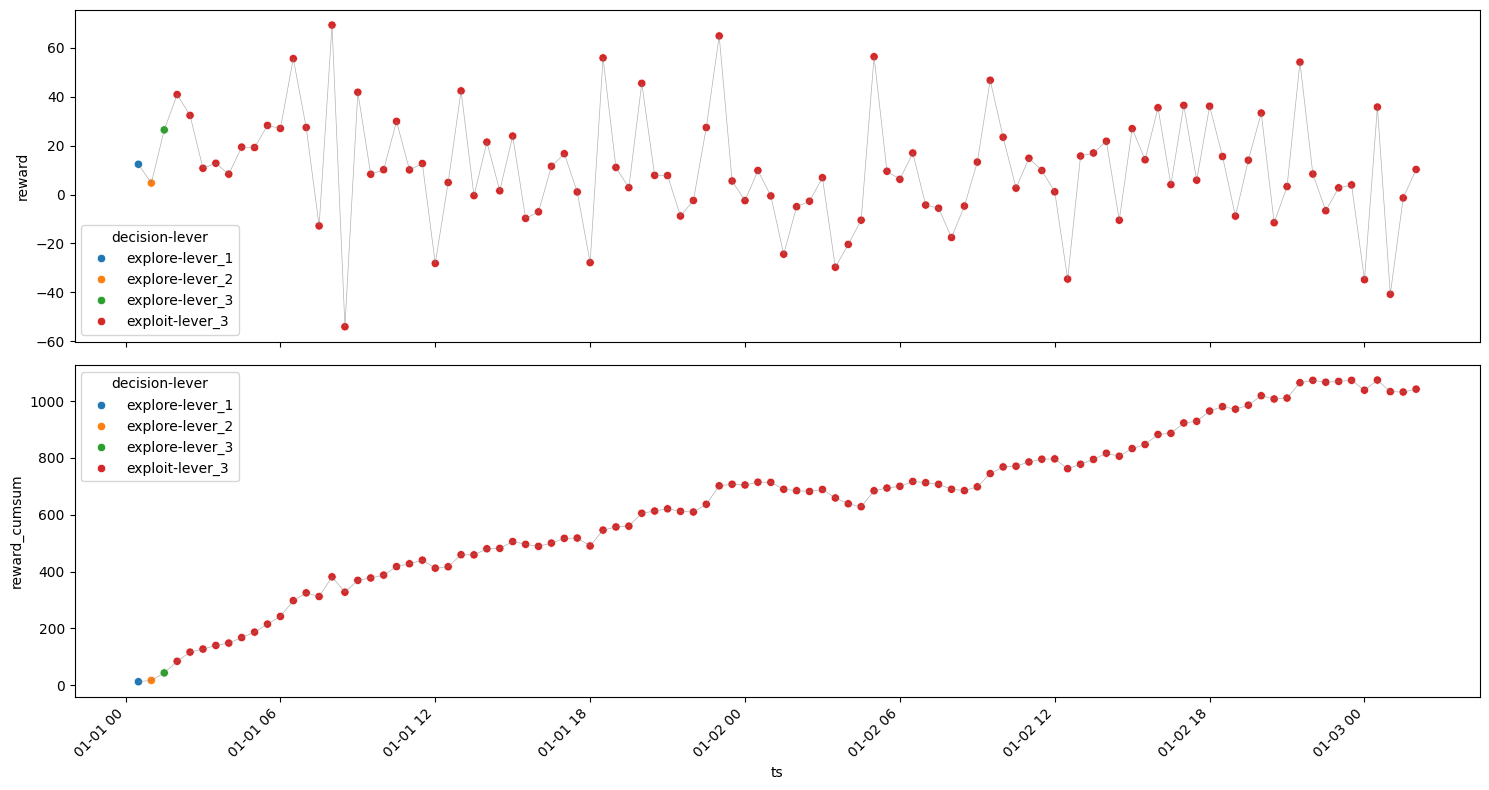

In [46]:
exploit_rewarddf = model.rewardsdf
get_metrics(exploit_rewarddf);
plot_reward(exploit_rewarddf);

### Selective Exploitation

In [47]:
model = Model(levers)

for _ in range(3):
    model.explore(next(levers_iterator))

model.chosen_lever = "lever_1"

for i in range(97):
    model.exploit()

,decision_idx,decision,seq,ts,lever,reward,reward_cumsum
0,1,explore,1,2024-01-01 00:30:00,lever_1,9.659453,9.659453
1,1,explore,2,2024-01-01 01:00:00,lever_2,12.143167,21.802621
2,1,explore,3,2024-01-01 01:30:00,lever_3,30.012687,51.815308
3,2,exploit,4,2024-01-01 02:00:00,lever_1,2.820648,54.635956
4,2,exploit,5,2024-01-01 02:30:00,lever_1,12.979665,67.615621
...,...,...,...,...,...,...,...
95,2,exploit,96,2024-01-03 00:00:00,lever_1,10.656235,990.481245
96,2,exploit,97,2024-01-03 00:30:00,lever_1,10.634908,1001.116153
97,2,exploit,98,2024-01-03 01:00:00,lever_1,15.071912,1016.188066
98,2,exploit,99,2024-01-03 01:30:00,lever_1,8.861699,1025.049765


,lever,decision,ts_count,ts_min,reward_min,reward_mean,reward_max,reward_sum,reward_std
1,lever_1,explore,1,2024-01-01 00:30:00,9.659453,9.659453,9.659453,9.659453,NaN
2,lever_2,explore,1,2024-01-01 01:00:00,12.143167,12.143167,12.143167,12.143167,NaN
3,lever_3,explore,1,2024-01-01 01:30:00,30.012687,30.012687,30.012687,30.012687,NaN
0,lever_1,exploit,97,2024-01-01 02:00:00,-2.310492,10.128445,24.965426,982.459133,5.075357



        Iterations      : 100
        Optimum Reward  : 3001.268693515948
        Total Reward    : 1034.2744402873932 
        Regret          : 1966.994253228555
        


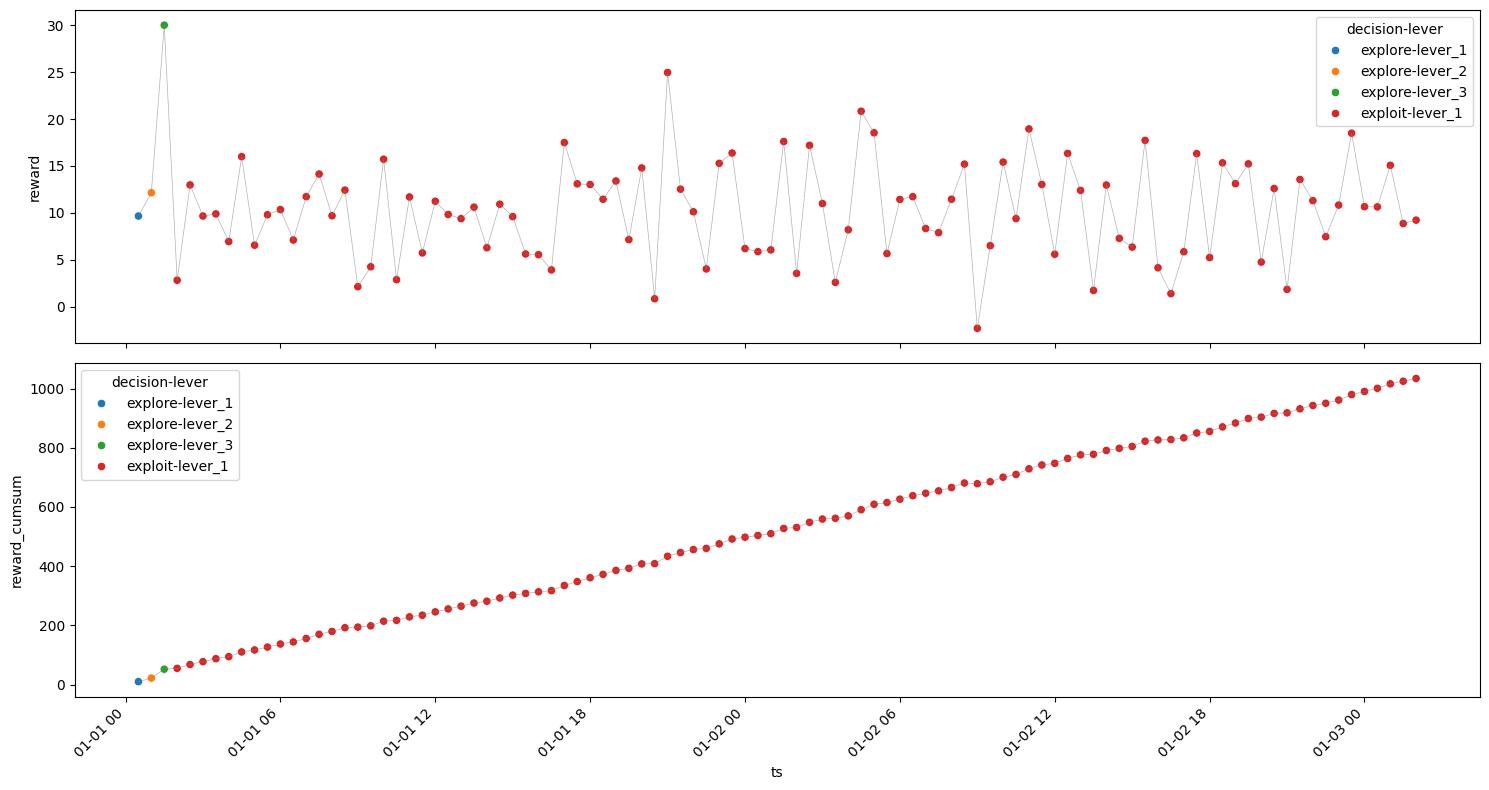

In [48]:
exploit_rewarddf = model.rewardsdf
get_metrics(exploit_rewarddf);
plot_reward(exploit_rewarddf);

In [49]:
model = Model(levers)

for _ in range(3):
    model.explore(next(levers_iterator))

model.chosen_lever = "lever_2"

for i in range(97):
    model.exploit()


,decision_idx,decision,seq,ts,lever,reward,reward_cumsum
0,1,explore,1,2024-01-01 00:30:00,lever_1,1.651808,1.651808
1,1,explore,2,2024-01-01 01:00:00,lever_2,8.004524,9.656332
2,1,explore,3,2024-01-01 01:30:00,lever_3,50.548125,60.204457
3,2,exploit,4,2024-01-01 02:00:00,lever_2,2.344362,62.548819
4,2,exploit,5,2024-01-01 02:30:00,lever_2,8.086630,70.635449
...,...,...,...,...,...,...,...
95,2,exploit,96,2024-01-03 00:00:00,lever_2,7.472829,813.787987
96,2,exploit,97,2024-01-03 00:30:00,lever_2,7.633158,821.421145
97,2,exploit,98,2024-01-03 01:00:00,lever_2,6.388255,827.809400
98,2,exploit,99,2024-01-03 01:30:00,lever_2,6.385902,834.195302


,lever,decision,ts_count,ts_min,reward_min,reward_mean,reward_max,reward_sum,reward_std
0,lever_1,explore,1,2024-01-01 00:30:00,1.651808,1.651808,1.651808,1.651808,NaN
2,lever_2,explore,1,2024-01-01 01:00:00,8.004524,8.004524,8.004524,8.004524,NaN
3,lever_3,explore,1,2024-01-01 01:30:00,50.548125,50.548125,50.548125,50.548125,NaN
1,lever_2,exploit,97,2024-01-01 02:00:00,2.344362,8.066946,13.980817,782.493768,2.626373



        Iterations      : 100
        Optimum Reward  : 5054.81254840199
        Total Reward    : 842.6982256683087 
        Regret          : 4212.114322733682
        


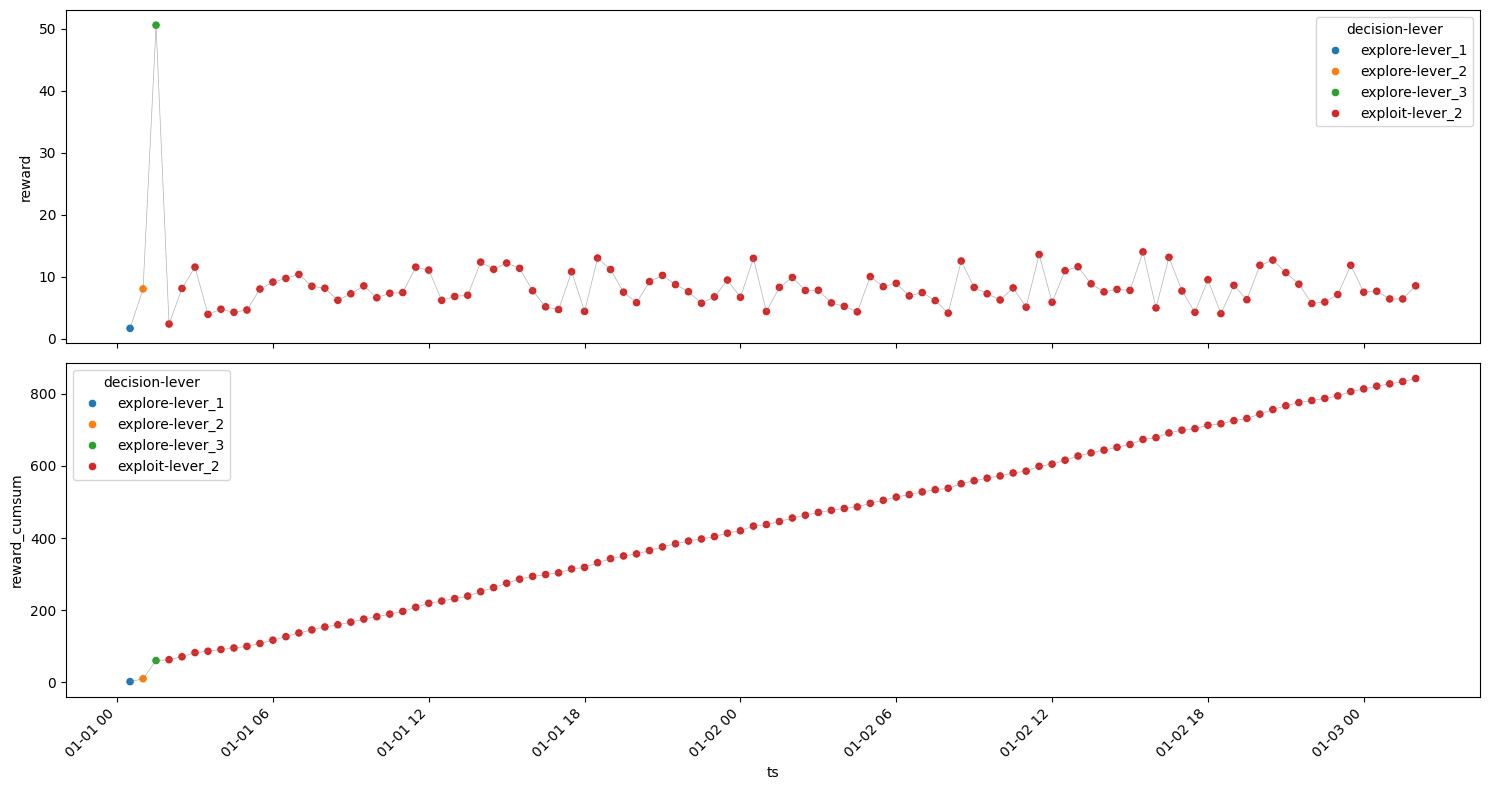

In [50]:
exploit_rewarddf = model.rewardsdf
get_metrics(exploit_rewarddf);
plot_reward(exploit_rewarddf);

In [51]:
model = Model(levers)

for _ in range(3):
    model.explore(next(levers_iterator))

model.chosen_lever = "lever_3"

for i in range(97):
    model.exploit()

,decision_idx,decision,seq,ts,lever,reward,reward_cumsum
0,1,explore,1,2024-01-01 00:30:00,lever_1,8.439506,8.439506
1,1,explore,2,2024-01-01 01:00:00,lever_2,8.358901,16.798407
2,1,explore,3,2024-01-01 01:30:00,lever_3,17.474506,34.272913
3,2,exploit,4,2024-01-01 02:00:00,lever_3,27.112797,61.385710
4,2,exploit,5,2024-01-01 02:30:00,lever_3,-28.566706,32.819004
...,...,...,...,...,...,...,...
95,2,exploit,96,2024-01-03 00:00:00,lever_3,17.048495,477.303083
96,2,exploit,97,2024-01-03 00:30:00,lever_3,18.085288,495.388371
97,2,exploit,98,2024-01-03 01:00:00,lever_3,-6.082738,489.305633
98,2,exploit,99,2024-01-03 01:30:00,lever_3,52.858562,542.164195


,lever,decision,ts_count,ts_min,reward_min,reward_mean,reward_max,reward_sum,reward_std
0,lever_1,explore,1,2024-01-01 00:30:00,8.439506,8.439506,8.439506,8.439506,NaN
1,lever_2,explore,1,2024-01-01 01:00:00,8.358901,8.358901,8.358901,8.358901,NaN
3,lever_3,explore,1,2024-01-01 01:30:00,17.474506,17.474506,17.474506,17.474506,NaN
2,lever_3,exploit,97,2024-01-01 02:00:00,-49.483380,5.377423,61.015972,521.609997,22.323921



        Iterations      : 100
        Optimum Reward  : 1747.4506107974335
        Total Reward    : 555.882909340998 
        Regret          : 1191.5677014564353
        


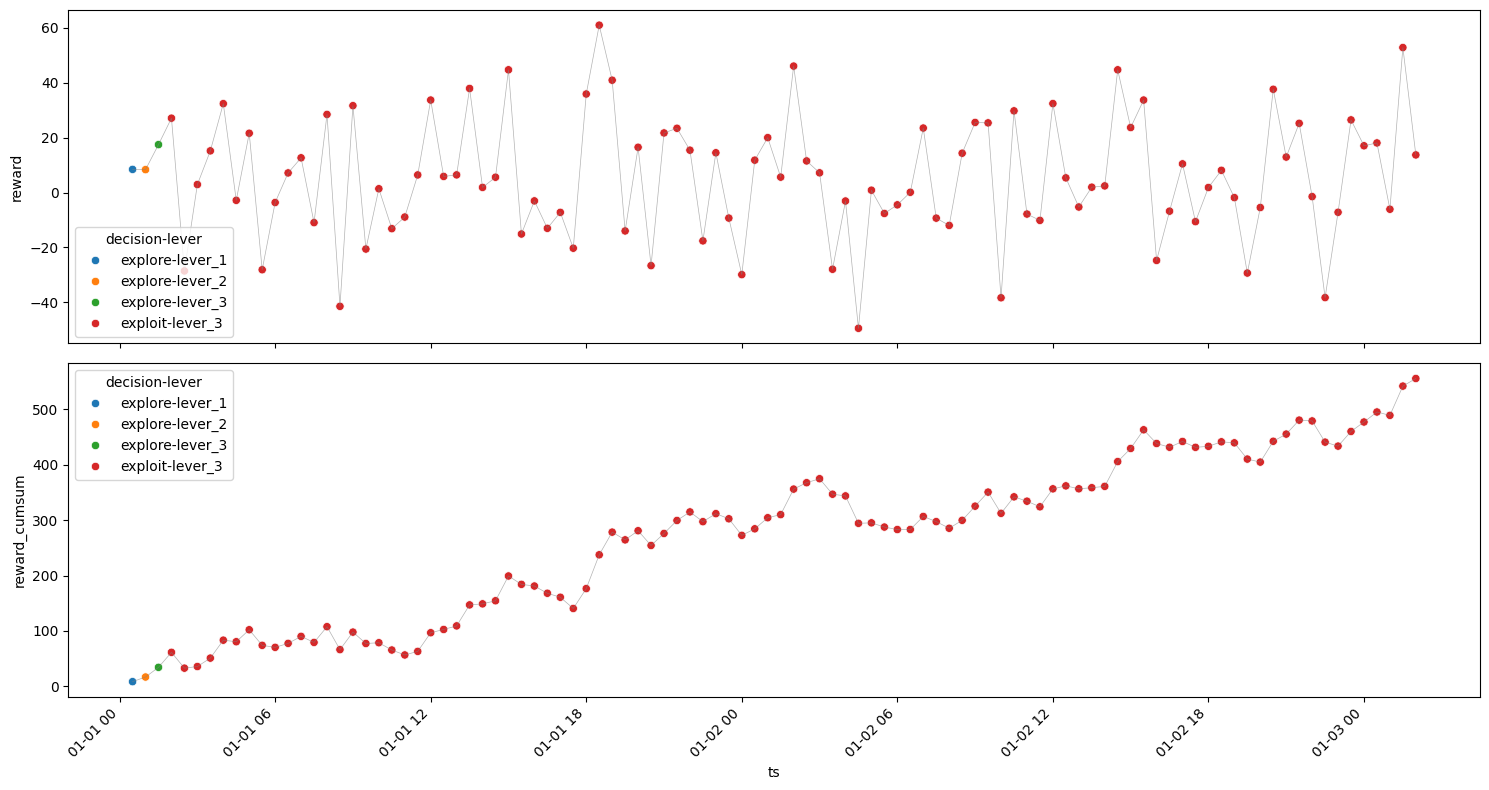

In [52]:
exploit_rewarddf = model.rewardsdf
get_metrics(exploit_rewarddf);
plot_reward(exploit_rewarddf);

## Alternative Sequentially Exploration & Exploitation


In [53]:
def explore_exploit(
    n_iterations=100,
    explore_iters=10,
    exploit_iters=10,
    levers=levers,
):

    model = Model(levers)
    run_explore = True

    explore_counter, exploit_counter = 0, 0

    for i in range(n_iterations):
        if run_explore:
            model.explore()
            explore_counter += 1
        else:
            model.exploit()
            exploit_counter += 1

        if explore_counter == explore_iters:
            run_explore = False
            explore_counter = 0

        if exploit_counter == exploit_iters:
            run_explore = True
            exploit_counter = 0

    return model

In [54]:
model = explore_exploit(
    n_iterations=100,
    explore_iters=10,
    exploit_iters=10,
    levers=["lever_1", "lever_2", "lever_3"],
)

,decision_idx,decision,seq,ts,lever,reward,reward_cumsum
0,1,explore,1,2024-01-01 00:30:00,lever_2,11.602274,11.602274
1,1,explore,2,2024-01-01 01:00:00,lever_1,8.593368,20.195642
2,1,explore,3,2024-01-01 01:30:00,lever_1,4.981252,25.176894
3,1,explore,4,2024-01-01 02:00:00,lever_1,0.710708,25.887603
4,1,explore,5,2024-01-01 02:30:00,lever_1,10.495656,36.383259
...,...,...,...,...,...,...,...
95,10,exploit,96,2024-01-03 00:00:00,lever_1,15.979654,626.331814
96,10,exploit,97,2024-01-03 00:30:00,lever_1,4.769553,631.101367
97,10,exploit,98,2024-01-03 01:00:00,lever_1,5.924406,637.025773
98,10,exploit,99,2024-01-03 01:30:00,lever_1,5.738012,642.763785


,lever,decision,ts_count,ts_min,reward_min,reward_mean,reward_max,reward_sum,reward_std
3,lever_2,explore,16,2024-01-01 00:30:00,3.250273,9.301360,13.315404,148.821758,2.951434
1,lever_1,explore,16,2024-01-01 01:00:00,0.710708,8.856251,17.026520,141.700018,4.411329
4,lever_3,explore,18,2024-01-01 04:00:00,-26.013159,-1.841319,34.004426,-33.143750,15.726512
2,lever_2,exploit,30,2024-01-01 05:30:00,3.026765,7.929011,13.472458,237.870341,2.930462
0,lever_1,exploit,20,2024-01-02 01:30:00,-0.477555,7.724160,16.901865,154.483199,4.633420



        Iterations      : 100
        Optimum Reward  : 930.1359882889254
        Total Reward    : 649.7315662863538 
        Regret          : 280.40442200257166
        


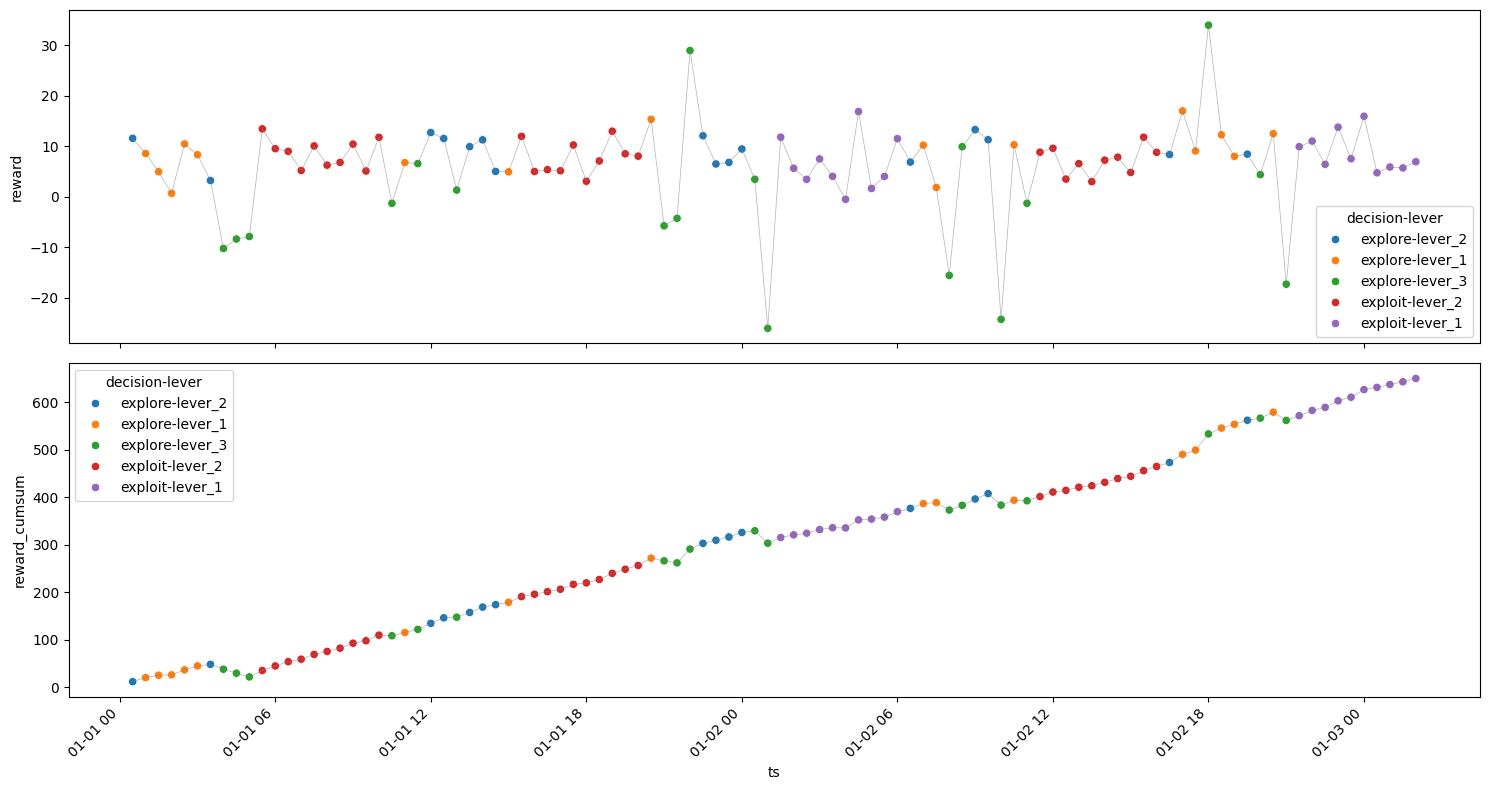

In [55]:

experiment_rewarddf = model.rewardsdf
get_metrics(experiment_rewarddf);
plot_reward(experiment_rewarddf);

In [56]:
model = explore_exploit(
    n_iterations=100,
    explore_iters=5,
    exploit_iters=10,
    levers=levers,
)

,decision_idx,decision,seq,ts,lever,reward,reward_cumsum
0,1,explore,1,2024-01-01 00:30:00,lever_1,18.212886,18.212886
1,1,explore,2,2024-01-01 01:00:00,lever_2,0.276046,18.488932
2,1,explore,3,2024-01-01 01:30:00,lever_1,4.333082,22.822014
3,1,explore,4,2024-01-01 02:00:00,lever_1,8.247737,31.069751
4,1,explore,5,2024-01-01 02:30:00,lever_1,2.898597,33.968348
...,...,...,...,...,...,...,...
95,14,exploit,96,2024-01-03 00:00:00,lever_1,18.787860,788.116315
96,14,exploit,97,2024-01-03 00:30:00,lever_1,4.416812,792.533126
97,14,exploit,98,2024-01-03 01:00:00,lever_1,15.055431,807.588557
98,14,exploit,99,2024-01-03 01:30:00,lever_1,20.037969,827.626526


,lever,decision,ts_count,ts_min,reward_min,reward_mean,reward_max,reward_sum,reward_std
1,lever_1,explore,18,2024-01-01 00:30:00,2.898597,10.902489,26.959597,196.244793,7.065350
3,lever_2,explore,8,2024-01-01 01:00:00,0.276046,7.416746,15.013949,59.333966,4.543810
0,lever_1,exploit,35,2024-01-01 03:00:00,-1.566631,9.307972,20.037969,325.779033,6.051078
5,lever_3,explore,9,2024-01-01 08:00:00,-33.041389,7.595653,37.725409,68.360874,20.178987
4,lever_3,exploit,20,2024-01-01 18:00:00,-31.698557,4.458280,37.703643,89.165593,20.111780
2,lever_2,exploit,10,2024-01-02 16:30:00,5.470575,9.334936,12.940514,93.349360,2.609912



        Iterations      : 100
        Optimum Reward  : 1090.2488522420047
        Total Reward    : 832.2336194730277 
        Regret          : 258.01523276897694
        


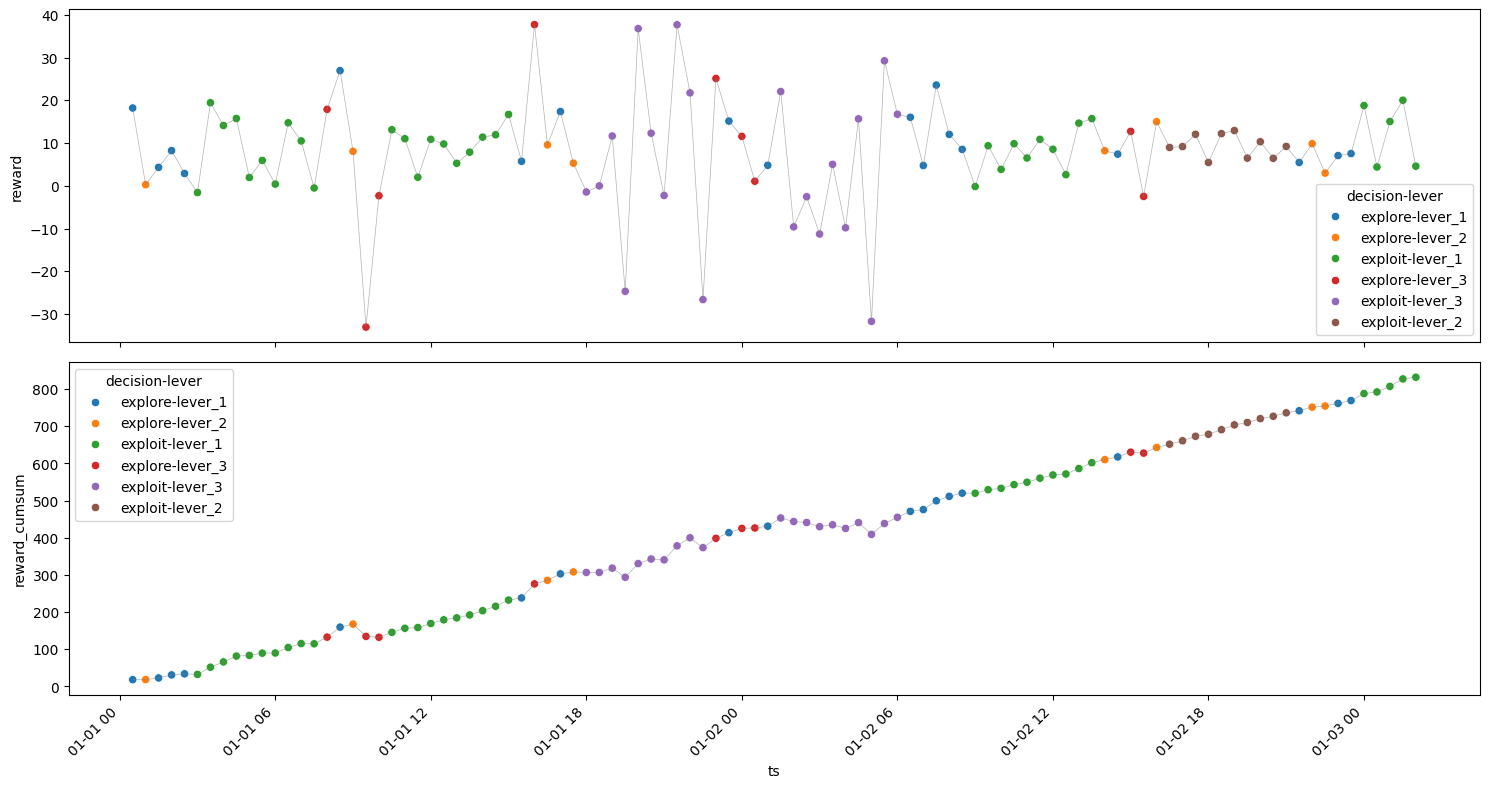

In [57]:
experiment_rewarddf = model.rewardsdf
get_metrics(experiment_rewarddf);
plot_reward(experiment_rewarddf);

## Epsilon ($\epsilon$) Greedy

In [58]:
def epsilon_greedy(
    n_iterations=100,
    epsilon=0.2,
    levers=levers
):

    model = Model(levers)

    model.explore()
    
    for i in range(n_iterations):

        p = np.random.random()
        
        if p < epsilon:
            model.explore()
        else:
            model.exploit()

    return model

### $\epsilon$ = 0.1

In [63]:
model = epsilon_greedy(
    n_iterations=100,
    epsilon=0.1,
    levers=levers
)

,decision_idx,decision,seq,ts,lever,reward,reward_cumsum
0,1,explore,1,2024-01-01 00:30:00,lever_1,7.664781,7.664781
1,2,exploit,2,2024-01-01 01:00:00,lever_1,12.148483,19.813264
2,2,exploit,3,2024-01-01 01:30:00,lever_1,0.353288,20.166552
3,2,exploit,4,2024-01-01 02:00:00,lever_1,6.981516,27.148068
4,2,exploit,5,2024-01-01 02:30:00,lever_1,16.919398,44.067466
...,...,...,...,...,...,...,...
96,8,exploit,97,2024-01-03 00:30:00,lever_2,8.379767,946.212530
97,8,exploit,98,2024-01-03 01:00:00,lever_2,12.359732,958.572261
98,8,exploit,99,2024-01-03 01:30:00,lever_2,12.277500,970.849761
99,8,exploit,100,2024-01-03 02:00:00,lever_2,4.568695,975.418456


,lever,decision,ts_count,ts_min,reward_min,reward_mean,reward_max,reward_sum,reward_std
1,lever_1,explore,3,2024-01-01 00:30:00,7.664781,9.141559,11.629224,27.424676,2.166938
0,lever_1,exploit,65,2024-01-01 01:00:00,-0.569958,10.523807,21.448306,684.047428,5.602826
3,lever_2,explore,1,2024-01-02 10:30:00,12.232801,12.232801,12.232801,12.232801,NaN
2,lever_2,exploit,32,2024-01-02 11:00:00,0.458347,8.143939,13.130506,260.606047,2.953218



        Iterations      : 101
        Optimum Reward  : 1235.5128965131642
        Total Reward    : 984.3109510946899 
        Regret          : 251.20194541847422
        


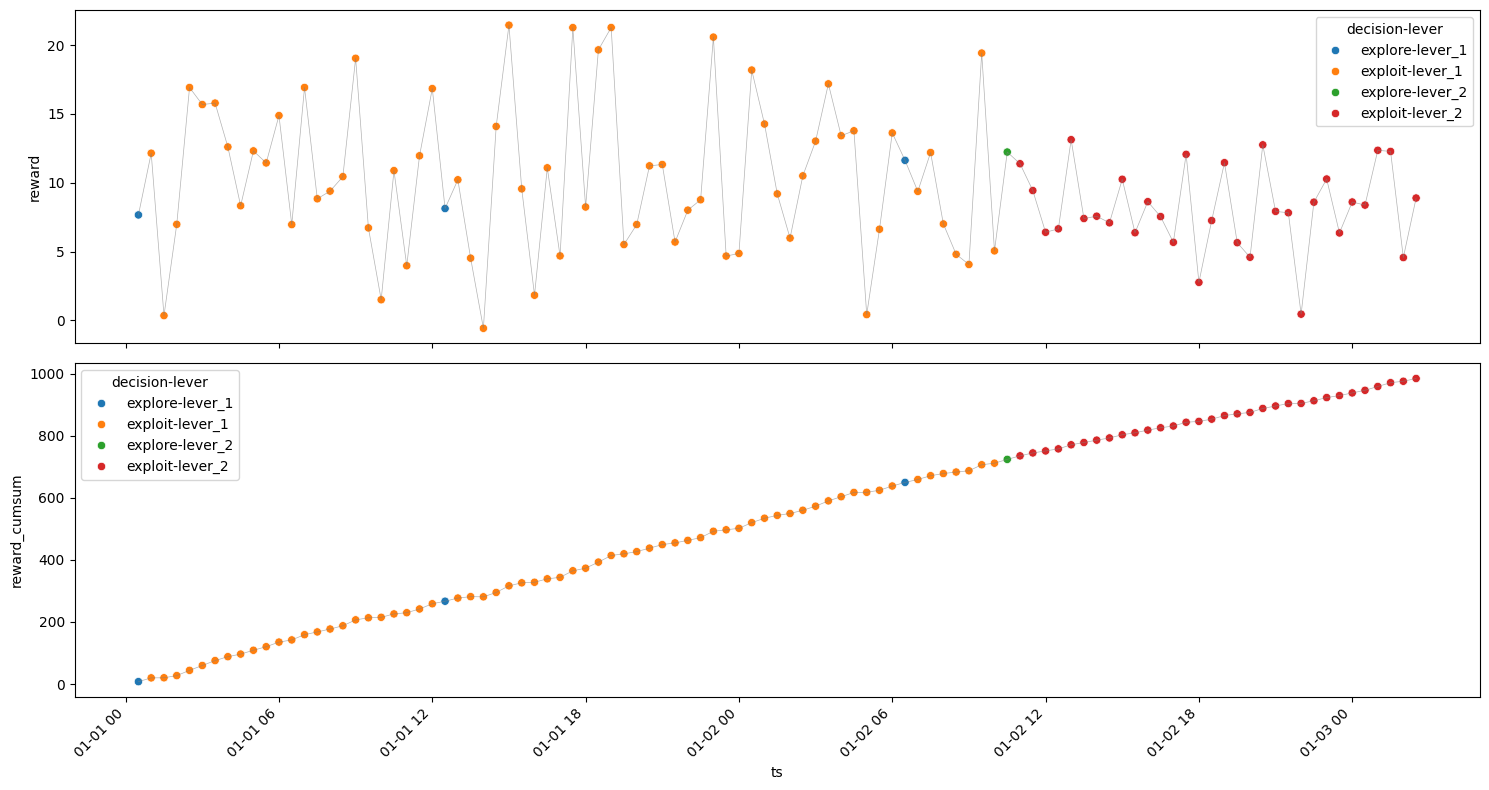

In [64]:
experiment_rewarddf = model.rewardsdf
get_metrics(experiment_rewarddf);
plot_reward(experiment_rewarddf);

### $\epsilon$ = 0.2

In [59]:
model = epsilon_greedy(
    n_iterations=100,
    epsilon=0.2,
    levers=levers
)

,decision_idx,decision,seq,ts,lever,reward,reward_cumsum
0,1,explore,1,2024-01-01 00:30:00,lever_2,9.612349,9.612349
1,1,explore,2,2024-01-01 01:00:00,lever_2,12.575885,22.188234
2,1,explore,3,2024-01-01 01:30:00,lever_1,6.475560,28.663794
3,2,exploit,4,2024-01-01 02:00:00,lever_2,10.851013,39.514807
4,2,exploit,5,2024-01-01 02:30:00,lever_2,7.310630,46.825437
...,...,...,...,...,...,...,...
96,32,exploit,97,2024-01-03 00:30:00,lever_1,3.903054,689.060955
97,32,exploit,98,2024-01-03 01:00:00,lever_1,7.037695,696.098650
98,32,exploit,99,2024-01-03 01:30:00,lever_1,4.268200,700.366850
99,32,exploit,100,2024-01-03 02:00:00,lever_1,10.121343,710.488192


,lever,decision,ts_count,ts_min,reward_min,reward_mean,reward_max,reward_sum,reward_std
3,lever_2,explore,5,2024-01-01 00:30:00,4.788047,8.935842,12.575885,44.679209,3.471230
1,lever_1,explore,9,2024-01-01 01:30:00,5.266297,11.145217,19.322485,100.306957,4.811788
2,lever_2,exploit,16,2024-01-01 02:00:00,3.325654,8.107633,12.351249,129.722130,2.538249
0,lever_1,exploit,42,2024-01-01 05:00:00,-0.633015,9.078395,14.957433,381.292595,4.071081
5,lever_3,explore,6,2024-01-01 12:00:00,-34.265149,4.750244,34.661452,28.501462,24.431227
4,lever_3,exploit,23,2024-01-01 12:30:00,-32.723174,1.364777,43.923508,31.389878,24.914059



        Iterations      : 101
        Optimum Reward  : 1125.666960071252
        Total Reward    : 715.8922311933887 
        Regret          : 409.77472887786337
        


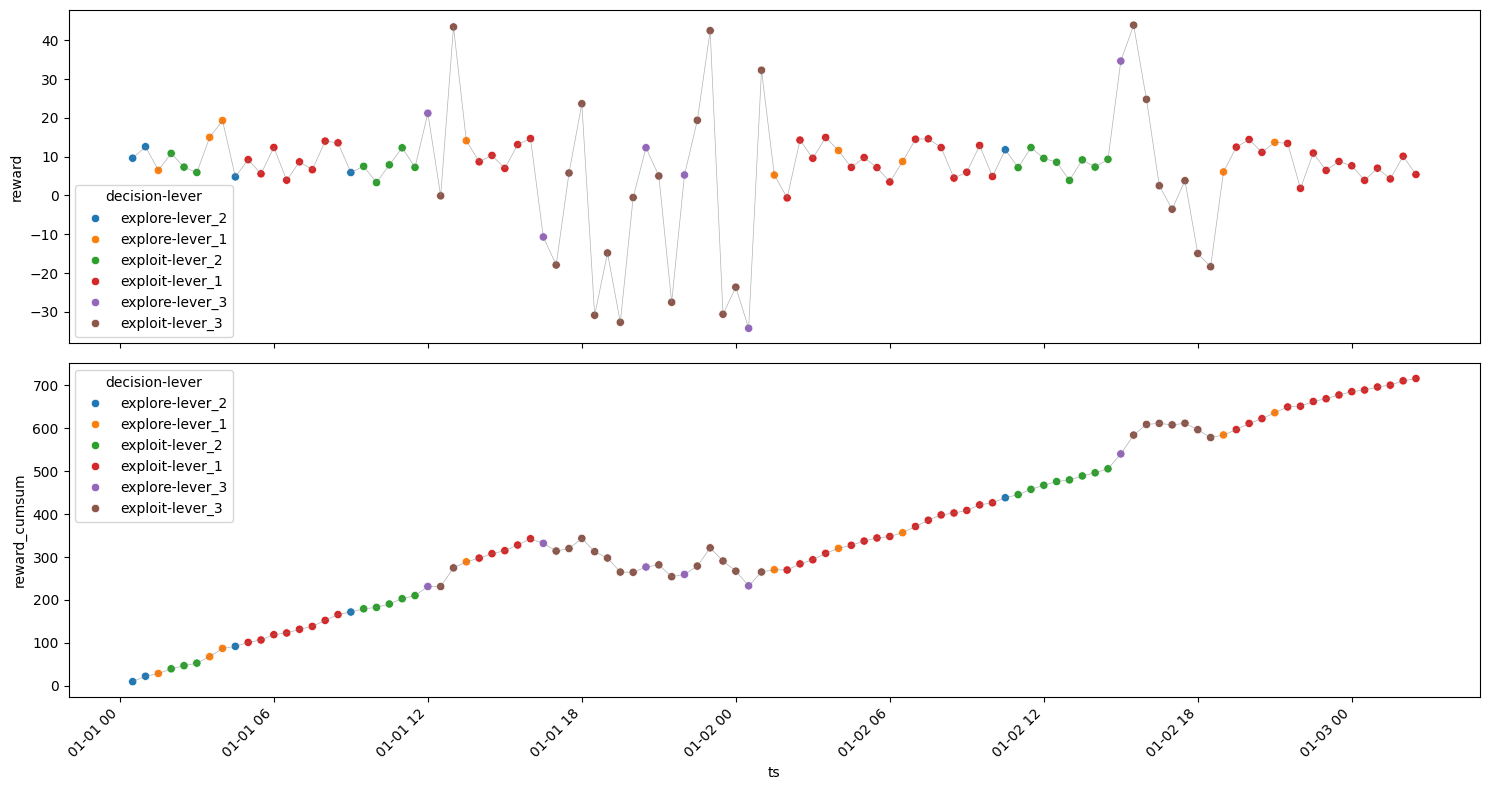

In [60]:
experiment_rewarddf = model.rewardsdf
get_metrics(experiment_rewarddf);
plot_reward(experiment_rewarddf);

### $\epsilon$ = 0.4

In [61]:
model = epsilon_greedy(
    n_iterations=100,
    epsilon=0.4,
    levers=levers
)

,decision_idx,decision,seq,ts,lever,reward,reward_cumsum
0,1,explore,1,2024-01-01 00:30:00,lever_1,15.809044,15.809044
1,2,exploit,2,2024-01-01 01:00:00,lever_1,9.093492,24.902536
2,2,exploit,3,2024-01-01 01:30:00,lever_1,10.734657,35.637193
3,2,exploit,4,2024-01-01 02:00:00,lever_1,10.941320,46.578513
4,2,exploit,5,2024-01-01 02:30:00,lever_1,4.065681,50.644194
...,...,...,...,...,...,...,...
96,44,exploit,97,2024-01-03 00:30:00,lever_1,9.511089,1155.778084
97,44,exploit,98,2024-01-03 01:00:00,lever_1,17.649373,1173.427456
98,44,exploit,99,2024-01-03 01:30:00,lever_1,12.390472,1185.817928
99,44,exploit,100,2024-01-03 02:00:00,lever_1,10.053769,1195.871697


,lever,decision,ts_count,ts_min,reward_min,reward_mean,reward_max,reward_sum,reward_std
1,lever_1,explore,18,2024-01-01 00:30:00,3.430817,12.128301,21.016254,218.309410,4.628499
0,lever_1,exploit,40,2024-01-01 01:00:00,-4.891923,10.387047,19.233034,415.481887,5.042699
3,lever_2,explore,6,2024-01-01 04:00:00,6.351694,7.918116,11.342849,47.508696,2.099544
5,lever_3,explore,12,2024-01-01 09:00:00,-15.543287,7.575968,55.207688,90.911615,20.559753
4,lever_3,exploit,19,2024-01-01 09:30:00,-74.514083,19.752219,57.070116,375.292156,29.656500
2,lever_2,exploit,6,2024-01-02 08:00:00,5.750992,9.258987,12.862105,55.553921,3.223247



        Iterations      : 101
        Optimum Reward  : 1994.9740930869036
        Total Reward    : 1203.057685922186 
        Regret          : 791.9164071647176
        


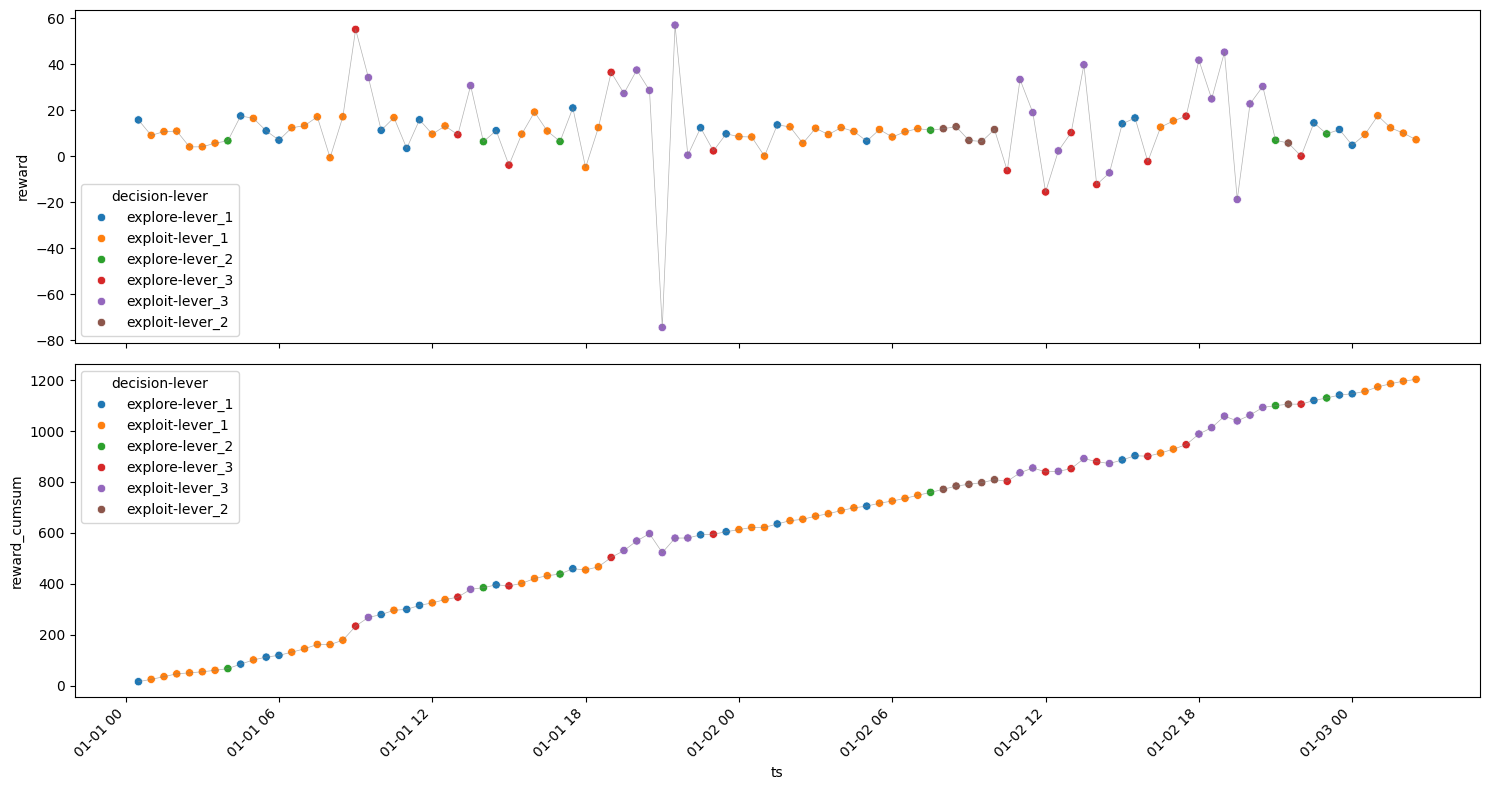

In [62]:
experiment_rewarddf = model.rewardsdf
get_metrics(experiment_rewarddf);
plot_reward(experiment_rewarddf);